In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.io import wavfile
from scipy.signal import decimate

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
INPUT_LIB = 'data/heartbeat/'
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

### Load data

In [4]:
def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == SAMPLE_RATE
    return b

In [5]:
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, 
       and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result
# 13
# 50: 13+13+13+13+8

In [6]:
# Apply Example
_dict = {1: {0:1, 1:1, 3:3}}
df = pd.DataFrame()
df = df.from_dict(_dict)
df
def plus3(a):
  return a + 3
_d = {1: 'one', 2: 'two', 3: 'three'}
df[2] = df[1].apply(plus3)
df[3] = df[1].apply(lambda x: _d[x])
df

1  2      3
0  1  4    one
1  1  4    one
3  3  6  three

In [7]:
df = pd.read_csv(INPUT_LIB + 'input.csv')
df['time_series'] = df['file_name'].apply(load_wav_file, 
                                          path=INPUT_LIB + 'set_a/')    
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, 
                                            length=MAX_LEN) 

In [8]:
df.head()

index  ... len_series
0      0  ...     396900
1      1  ...     396900
2      2  ...     396900
3      3  ...     396900
4      4  ...     396900

[5 rows x 5 columns]

### Split the data

In [9]:
x_data = np.stack(df['time_series'].values, axis=0) # [[1], [2], [3], ]
y_data = pd.get_dummies(df['labels'].values.tolist()).values # [0, 1, 2] --> [1, 0, 0], [0, 1, 0], [0, 0, 1]

In [10]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['file_name'].values, test_size=0.25)

In [11]:
# print(f"X train shape: {x_train.shape}")
# print(f"X test  shape: {x_test.shape}")

In [12]:
x_train = decimate(x_train, 8, axis=1)
x_train = decimate(x_train, 8, axis=1)
x_train = decimate(x_train, 4, axis=1) # 256Hz --> 1Hz

x_test = decimate(x_test, 8, axis=1)
x_test = decimate(x_test, 8, axis=1)
x_test = decimate(x_test, 4, axis=1)

In [13]:
# print(f"X train shape: {x_train.shape}")
# print(f"X test  shape: {x_test.shape}")

In [14]:
x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

In [15]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [16]:
print(f"X train shape: {x_train.shape}")
print(f"X test  shape: {x_test.shape}")

X train shape: (132, 1551, 1)
X test  shape: (44, 1551, 1)


### Define the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
def create_cnn(pkeep=0.1):    
    model = Sequential()    
    
    model.add(Conv1D(filters=2, kernel_size=9, 
                     padding='same',activation='relu', 
                     input_shape=x_train.shape[1:]))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))

    model.add(Conv1D(filters=2, kernel_size=9,
                     padding='same',activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))
    
    model.add(Conv1D(filters=4, kernel_size=9,
                     activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))
    
    model.add(Conv1D(filters=6, kernel_size=9, 
                     padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=6, padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(1-pkeep))
    model.add(Dense(units=3, activation = 'softmax')) 
    # Logits --> Softmax --> Loss
    # [15, 0.5, 0.001] --> [0.9, 0.045, 0.005]
    # print(model.summary())    
    return model

### Train the model

In [26]:
pkeep = 0.5
batch_size = 8
epochs = 100

In [27]:
model = create_cnn(pkeep)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer = opt, 
              metrics = ['accuracy'])

In [ ]:
# print(model.summary())

In [29]:
hists = model.fit(x_train, y_train, 
                  batch_size=batch_size, epochs=epochs, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor="val_loss", patience=10, 
                                           restore_best_weights=True)]) # 0,....71 (best), ... 81.

Epoch 1/200
14/14 [==============================] - 1s 27ms/step - loss: 1.1867 - accuracy: 0.3238 - val_loss: 1.0819 - val_accuracy: 0.4074
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 1.1097 - accuracy: 0.3048 - val_loss: 1.0828 - val_accuracy: 0.3333
Epoch 3/200
14/14 [==============================] - 0s 12ms/step - loss: 1.0754 - accuracy: 0.4190 - val_loss: 1.0794 - val_accuracy: 0.4074
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 1.0593 - accuracy: 0.3905 - val_loss: 1.0823 - val_accuracy: 0.4815
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 1.0220 - accuracy: 0.5143 - val_loss: 1.0701 - val_accuracy: 0.4074
Epoch 6/200
14/14 [==============================] - 0s 12ms/step - loss: 1.0017 - accuracy: 0.5238 - val_loss: 1.0606 - val_accuracy: 0.4444
Epoch 7/200
14/14 [==============================] - 0s 12ms/step - loss: 1.0268 - accuracy: 0.5143 - val_loss: 1.0511 - val_accuracy: 0.4444
Epoch 

### Plot the training result

In [30]:
loss = hists.history['loss']
val_loss = hists.history['val_loss']

In [31]:
acc = hists.history['accuracy']
val_acc = hists.history['val_accuracy']

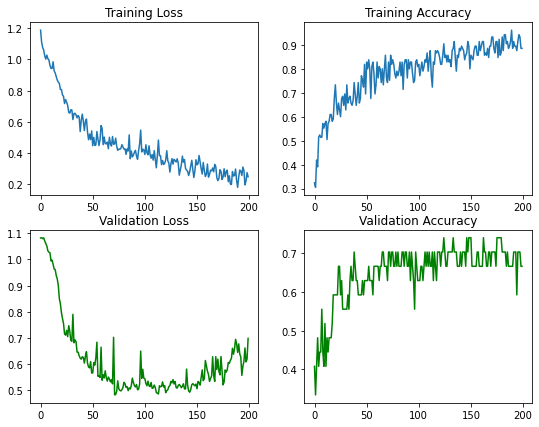

In [32]:
plt.figure(figsize=(9, 7))

plt.subplot(221)
plt.title("Training Loss")
plt.plot(loss)

plt.subplot(222)
plt.title("Training Accuracy")
plt.plot(acc,)

plt.subplot(223)
plt.title("Validation Loss")
plt.plot(val_loss,  color='green')

plt.subplot(224)
plt.title("Validation Accuracy")
plt.plot(val_acc, color='green')

plt.show()

### Plot the test result

In [33]:
preds = tf.argmax(model.predict(x_test), 1) # [[0.5, 0.2, 0.3], [], ...] --> [0, ...]
labels = tf.argmax(y_test, 1)

In [34]:
accuracy_op = tf.keras.metrics.Accuracy()
test_acc = accuracy_op(preds, labels).numpy()

Accuracy = 0.73


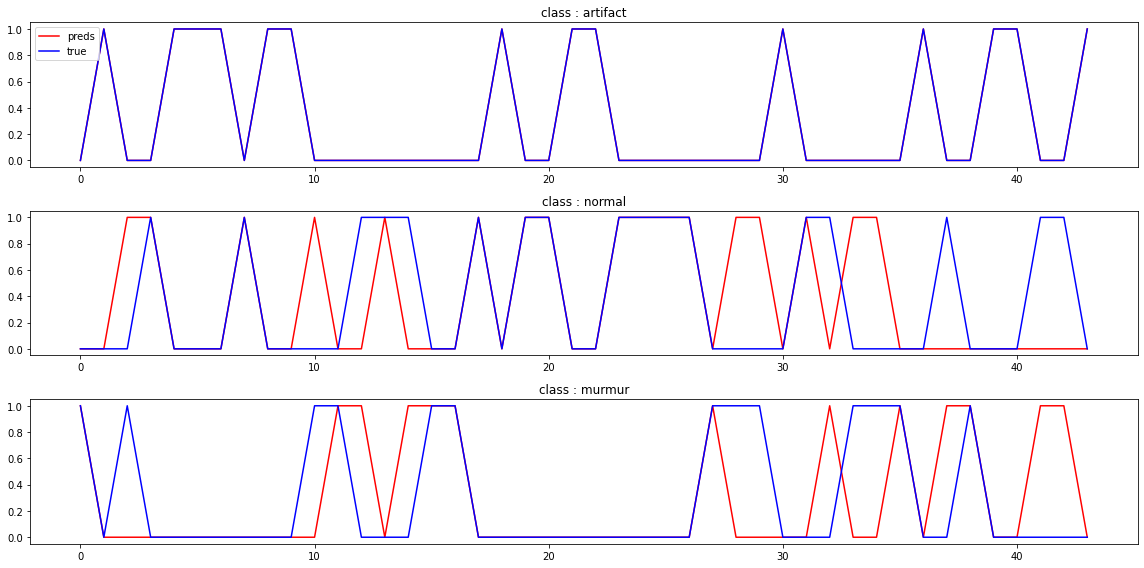

In [35]:
result = pd.get_dummies(preds).values
fig = plt.figure(figsize=(16, 8))
print(f"Accuracy = {test_acc:.2f}")
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(result[:,i], c='r') # [44, 3] --> result[20] --> [0, 0, 1]
    plt.plot(y_test[:,i], c='b')
    plt.title(f"class : {CLASSES[i]}")
    if i == 0:
        plt.legend(['preds',  'true'])
fig.tight_layout()

In [38]:
mis_preds = [ i for i in range(len(labels)) if (preds[i].numpy() != labels[i].numpy())]

num = len(mis_preds)

print(f"the number of mis-prediction: {num}")

the number of mis-prediction: 12


In [ ]:
# odds = [i for i in range(10) if i%2!=0]
# print(odds)

[1, 3, 5, 7, 9]


In [ ]:
row = 4
col = int(np.ceil(num/row))

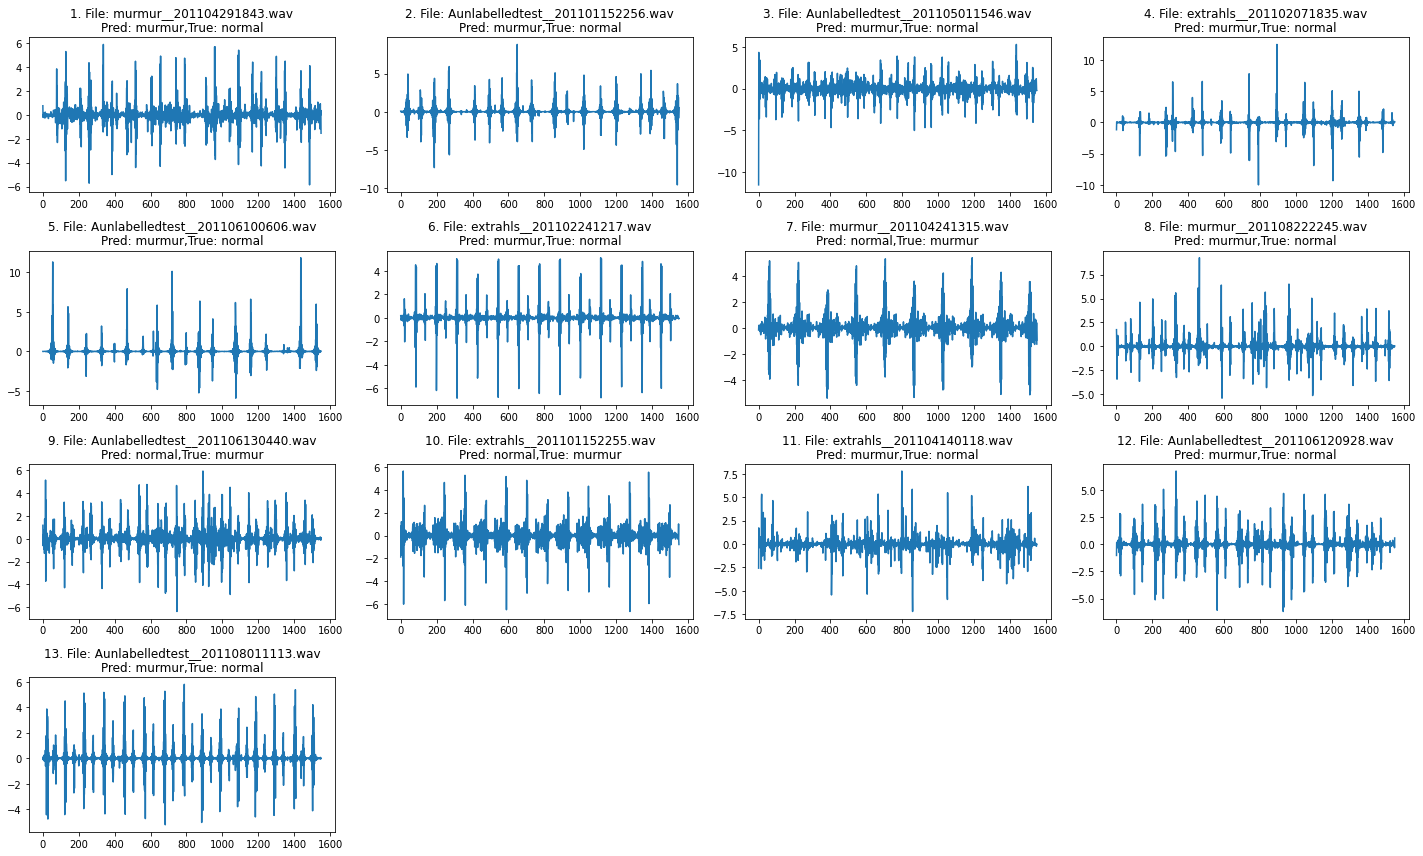

In [ ]:
fig = plt.figure(figsize=(20, 12))

for i in range(num):
    plt.subplot(row, col, i+1)
    plt.plot(x_test[mis_preds[i]]) # mis_preds: [0, 10, 15]
    plt.title(f"{i+1}. File: {test_filenames[i]}\n" 
              f"Pred: {CLASSES[preds[mis_preds[i]]]},"
              f"True: {CLASSES[labels[mis_preds[i]]]}")
    
fig.tight_layout()